In [15]:
import sys
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from scipy.fft import rfft
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from aeon.utils.validation import check_n_jobs
from aeon.utils.numba.stats import row_mean, row_std, row_slope

In [16]:
data_root = '/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/data/raw/'

In [18]:
class TimeSeriesDataset:
    def __init__(self, data_dir, labels_file, filename_col='filename', label_col='label', feature_cols=None):
        """
        Args:
            data_dir (str): Path to directory with CSV files.
            labels_file (str): Path to master CSV file.
            filename_col (str): Column name for filenames in master CSV.
            label_col (str): Column name for labels in master CSV.
            feature_cols (list or str): List of columns to load (e.g. ['acc_x', 'acc_y']).
                                        If None, loads all columns.
        """
        self.data_dir = data_dir
        
        # 1. Normalize feature_cols to always be a list
        # This handles cases where user passes "sensor_val" (str) or ["sensor_val"] (list)
        if isinstance(feature_cols, str):
            self.feature_cols = [feature_cols]
        else:
            self.feature_cols = feature_cols
            
        self.metadata = pd.read_csv(labels_file)
        
        # Verify files exist to avoid errors later
        self.metadata['full_path'] = self.metadata[filename_col].apply(
            lambda x: os.path.join(data_dir, str(x) if str(x).endswith('.csv') else f"{x}.csv")
        )
        
        # Filter out files that don't exist
        original_count = len(self.metadata)
        self.metadata = self.metadata[self.metadata['full_path'].apply(os.path.exists)].copy()
        
        if len(self.metadata) < original_count:
            print(f"Warning: {original_count - len(self.metadata)} files were missing and excluded.")

        # Initialize Label Encoder
        self.label_encoder = LabelEncoder()
        self.metadata['encoded_label'] = self.label_encoder.fit_transform(self.metadata[label_col])
        self.classes_ = self.label_encoder.classes_

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        """
        Returns: 
            series: Numpy array of shape (Time_Steps, Num_Features)
            label: Integer label
        """
        row = self.metadata.iloc[idx]
        file_path = row['full_path']
        
        try:
            df = pd.read_csv(file_path)
            
            # 2. Logic to Select Columns
            if self.feature_cols is not None:
                # Check if all requested columns exist in this file
                if set(self.feature_cols).issubset(df.columns):
                    series = df[self.feature_cols].values
                else:
                    # Robust Error Handling: Don't guess. If columns are missing, skip/warn.
                    missing = list(set(self.feature_cols) - set(df.columns))
                    print(f"Error: Columns {missing} missing in {file_path}. Skipping.")
                    return np.array([]), -1
            else:
                # If no specific columns requested, take all values
                series = df.values
                
            return series, row['encoded_label']
            
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            return np.array([]), -1

    def get_splits(self, seed=42):
        """
        Loads ALL data into memory and splits it for Scikit-Learn.
        Returns: (X_train, y_train), (X_val, y_val), (X_test, y_test)
        """
        print(f"Loading {len(self)} multivariate time series into memory...")
        X = []
        y = []
        
        # Eagerly load all data
        for idx in range(len(self)):
            series, label = self[idx]
            # Ensure we only add valid data (non-empty arrays)
            if len(series) > 0:
                X.append(series)
                y.append(label)
        
        y = np.array(y)
        
        # Split 1: 70% Train, 30% Temp
        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y, test_size=0.3, stratify=y, random_state=seed
        )
        
        # Split 2: Divide Temp into Val (10%) and Test (20%)
        X_test, X_val, y_test, y_val = train_test_split(
            X_temp, y_temp, test_size=1/3, stratify=y_temp, random_state=seed
        )
        
        print(f"Data Split Complete: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")
        
        # Optional: Print shape of first item to verify dimensions
        if len(X_train) > 0:
            print(f"Sample shape (Time, Features): {X_train[0].shape}")
        
        return (X_train, y_train), (X_val, y_val), (X_test, y_test)




In [19]:
dataset = TimeSeriesDataset(
    data_dir=data_root+'/data',
    labels_file=data_root+'/SEP_class_labels.csv',
    filename_col='File',
    label_col='Label',
    feature_cols=['p3_flux_ic', 'p5_flux_ic','p7_flux_ic']  # Example of multiple columns
)
print(f"Classes detected: {dataset.classes_}")

# 2. Get the splits for your Scikit-Learn loop
(X_train, y_train), (X_val, y_val), (X_test, y_test) = dataset.get_splits()

# ... Continue with your existing GridSearch loop ...
# grid_search.fit(X_train, y_train)

Classes detected: [0 1]
Loading 2892 multivariate time series into memory...
Data Split Complete: Train=2024, Val=290, Test=578
Sample shape (Time, Features): (961, 3)


In [20]:
class MultivariateFFTFeaturizer(BaseEstimator, TransformerMixin):
    def __init__(self, window_size=360, n_coefficients=10):
        """
        window_size: The time window to focus on.
        n_coefficients: The number of low-frequency coefficients to keep per feature.
        """
        self.window_size = window_size
        self.n_coefficients = n_coefficients

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """
        X: List of numpy arrays. Each array is shape (Time, Features).
        """
        features = []
        
        for series in X:
            series = np.array(series)
            
            # Safety Check: Ensure data is at least 2D (Time, 1)
            if series.ndim == 1:
                series = series.reshape(-1, 1)
                
            T, num_features = series.shape
            
            # 1. Windowing (Pad or Truncate)
            if T >= self.window_size:
                # Truncate time, keep all features
                windowed = series[:self.window_size, :]
            else:
                # Pad time with zeros, match feature width
                padding = np.zeros((self.window_size - T, num_features))
                windowed = np.vstack([series, padding])
            
            # 2. FFT along Time Axis (axis=0)
            # We want to break down time patterns, not mix features together yet.
            fft_coeffs = rfft(windowed, axis=0)
            # print(f"FFT Coefficients Shape: {fft_coeffs.shape}")  # Debugging line
            magnitudes = np.abs(fft_coeffs)
            
            # 3. Select Top K Coefficients
            # magnitudes shape is (Frequency_Bins, Num_Features)
            # We take the first 'n_coefficients' rows
            top_k_matrix = magnitudes[:self.n_coefficients, :]
            
            # 4. Flatten for the Classifier
            # The classifier needs a 1D array. 
            # Output size = n_coefficients * num_features
            features.append(top_k_matrix.flatten())
            
        return np.array(features)

In [22]:
# The variables we want to test
window_sizes_to_test = [360, 180, 90, 45]
coefficients_to_test = [5, 10, 20, 30, 40, 50] # "k" values

results_storage = []

print(f"\nStarting Experiment on {len(X_train)} training samples...")
print("-" * 60)

# --- 4. THE EXPERIMENT LOOP ---

for win_size in window_sizes_to_test:
    print(f"Testing Window Size: {win_size} min")
    
    # Calculate total coefficients generated by rfft before top-k selection
    # rfft generates (window_size // 2 + 1) frequency bins
    num_features = 3  # We have 3 sensors: p3_flux_ic, p5_flux_ic, p7_flux_ic
    total_fft_bins = win_size // 2 + 1  # Number of frequency bins from rfft
    total_coeffs_generated = total_fft_bins * num_features  # Total before selecting top-k
    
    print(f"   -> FFT Frequency Bins Generated: {total_fft_bins}")
    print(f"   -> Total Coefficients Before Top-K Selection: {total_coeffs_generated}\n")
    
    # A. Define the Pipeline
    # We set a default n_coefficients=10, but GridSearchCV will overwrite this
    pipe = Pipeline([
        ('fft', MultivariateFFTFeaturizer(window_size=win_size)),
        ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
    ])
    
    # B. Define Hyperparameter Grid
    # We can also tune the Random Forest along with the FFT if desired
    param_grid = {
        'fft__n_coefficients': coefficients_to_test,
        'rf__n_estimators': [50, 100] 
    }
    
    # C. Run Grid Search
    # cv=3 means it splits training data into 3 chunks to validate internally
    grid = GridSearchCV(pipe, param_grid, cv=3, scoring='f1_weighted', verbose=1)
    grid.fit(X_train, y_train)
    
    # D. Extract Best Results for this Window
    best_k = grid.best_params_['fft__n_coefficients']
    best_acc = grid.best_score_
    best_n_estimators = grid.best_params_['rf__n_estimators']
    
    # Calculate total coefficients for best model (after top-k selection)
    total_coeffs_best = best_k * num_features
    
    print(f"   -> Best 'k' coeffs selected: {best_k}")
    print(f"   -> Total coefficients after top-K selection: {total_coeffs_best}")
    print(f"   -> Best n_estimators: {best_n_estimators}")
    print(f"   -> Best F1_score(weighted):   {best_acc:.4f}\n")
    
    # E. Save detailed results for later visualization
    # We want to capture the performance of EVERY k, not just the best one
    cv_results = pd.DataFrame(grid.cv_results_)
    
    for i, row in cv_results.iterrows():
        k_val = row['param_fft__n_coefficients']
        mean_score = row['mean_test_score']
        
        results_storage.append({
            'window_size': win_size,
            'fft_bins_generated': total_fft_bins,
            'total_coeffs_before_topk': total_coeffs_generated,
            'n_coefficients': k_val,
            'total_coeffs_after_topk': k_val * num_features,
            'F1_score_weighted': mean_score
        })

# --- 5. FINALIZE RESULTS ---
results_df = pd.DataFrame(results_storage)

print("-" * 60)
print("TOP 5 CONFIGURATIONS FOUND:")
print(results_df.sort_values(by='F1_score_weighted', ascending=False).head(5))

# Optional: Save to CSV for your visualization tool
results_df.to_csv(data_root+'../processed/spectral_tsf/experiment_results.csv', index=False)


Starting Experiment on 2024 training samples...
------------------------------------------------------------
Testing Window Size: 360 min
   -> FFT Frequency Bins Generated: 181
   -> Total Coefficients Before Top-K Selection: 543

Fitting 3 folds for each of 12 candidates, totalling 36 fits
   -> Best 'k' coeffs selected: 10
   -> Total coefficients after top-K selection: 30
   -> Best n_estimators: 50
   -> Best F1_score(weighted):   0.9051

Testing Window Size: 180 min
   -> FFT Frequency Bins Generated: 91
   -> Total Coefficients Before Top-K Selection: 273

Fitting 3 folds for each of 12 candidates, totalling 36 fits
   -> Best 'k' coeffs selected: 10
   -> Total coefficients after top-K selection: 30
   -> Best n_estimators: 50
   -> Best F1_score(weighted):   0.9043

Testing Window Size: 90 min
   -> FFT Frequency Bins Generated: 46
   -> Total Coefficients Before Top-K Selection: 138

Fitting 3 folds for each of 12 candidates, totalling 36 fits
   -> Best 'k' coeffs selected:

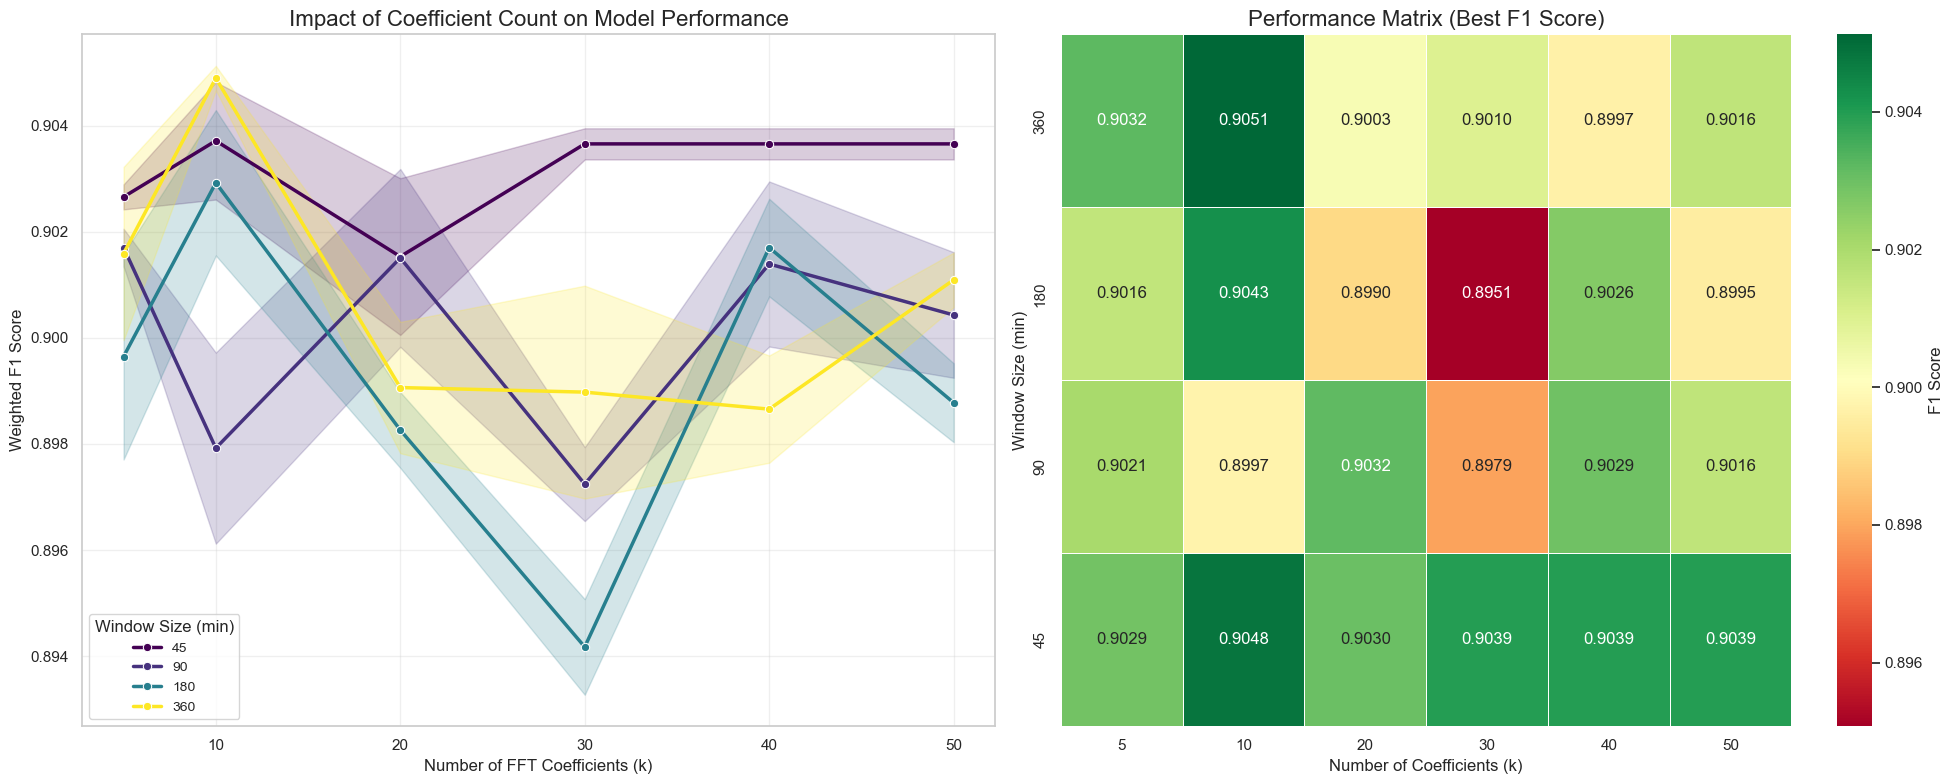

In [23]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(20, 8))

# --- Plot 1: Trend Lines (Performance vs. Coefficients) ---
plt.subplot(1, 2, 1)
sns.lineplot(
    data=results_df, 
    x='n_coefficients', 
    y='F1_score_weighted', 
    hue='window_size', 
    palette='viridis',
    marker='o',
    linewidth=2.5
)
plt.title("Impact of Coefficient Count on Model Performance", fontsize=16)
plt.xlabel("Number of FFT Coefficients (k)", fontsize=12)
plt.ylabel("Weighted F1 Score", fontsize=12)
plt.legend(title='Window Size (min)', fontsize=10)
plt.grid(True, alpha=0.3)

# --- Plot 2: Heatmap (The "Sweet Spot" Finder) ---
plt.subplot(1, 2, 2)

# FIX: Use pivot_table instead of pivot, and take the MAX score if duplicates exist
pivot_table = results_df.pivot_table(
    index='window_size', 
    columns='n_coefficients', 
    values='F1_score_weighted',
    aggfunc='max'  # <--- This solves the "duplicate entries" error
)

sns.heatmap(
    pivot_table, 
    annot=True, 
    fmt=".4f", 
    cmap="RdYlGn", 
    linewidths=.5,
    cbar_kws={'label': 'F1 Score'}
)
plt.title("Performance Matrix (Best F1 Score)", fontsize=16)
plt.xlabel("Number of Coefficients (k)", fontsize=12)
plt.ylabel("Window Size (min)", fontsize=12)
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

Integration with SlimTSF

In [24]:
def convert_to_slim_format(X_list, y_list, max_len=None):
    """
    Converts list of (Time, Channels) arrays to (N, Channels, Time) numpy block.
    """
    n_samples = len(X_list)
    n_channels = X_list[0].shape[1]
    
    # 1. Determine max time length if not provided (for padding)
    if max_len is None:
        max_len = max(x.shape[0] for x in X_list)
    
    # 2. Initialize 3D array (N, Channels, Time)
    # SLIM expects channels to be the second dimension
    X_3d = np.zeros((n_samples, n_channels, max_len))
    
    for i, x in enumerate(X_list):
        time_steps = x.shape[0]
        # Transpose (Time, Channels) -> (Channels, Time)
        x_transposed = x.T 
        # Fill the array (padding is naturally 0 due to np.zeros initialization)
        X_3d[i, :, :time_steps] = x_transposed
        
    return np.array(X_3d), np.array(y_list)

In [25]:
class WindowFFTFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, n_coefficients=5):
        self.n_coefficients = n_coefficients

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        """
        Input X shape: (n_cases, 1, window_size)
        SLIM passes data channel-by-channel.
        """
        # Remove the channel dimension since it's always 1 inside the loop
        # Shape becomes (n_cases, window_size)
        X_sq = X.squeeze(axis=1)
        
        # 1. Apply FFT along the time axis (axis 1)
        fft_coeffs = rfft(X_sq, axis=1)
        magnitudes = np.abs(fft_coeffs)
        
        # 2. Select Top K Coefficients (excluding DC component usually, but keeping 0 here for simplicity)
        # We ensure we don't ask for more coefficients than exist in the window
        limit = min(self.n_coefficients, magnitudes.shape[1])
        return magnitudes[:, :limit]

In [26]:
# 2. Convert to SLIM Format (N, Channels, Time)
X_train_slim, y_train_slim = convert_to_slim_format(X_train, y_train)
X_test_slim, y_test_slim = convert_to_slim_format(X_test, y_test)

print(f"SLIM Input Shape: {X_train_slim.shape}")

# 3. Initialize SLIM with Hybrid Features
# We combine standard statistical features (Mean, Std) with your Spectral features
fft_feature = WindowFFTFeatures(n_coefficients=5)

clf = SlimTimeSeriesForestClassifier(
    n_estimators=100,
    # Define window sizes relevant to your signal (e.g., 0.5s, 1s, 2s)
    windows=[64, 128], 
    # Inject your logic here:
    features=[
        row_mean,       # Capture shifts in baseline
        row_std,        # Capture energy/variance
        fft_feature     # Capture frequency components (Your Logic)
    ],
    sec_trans=True      # Enable global pooling (Max/Min of FFT coeffs across full series)
)

# 4. Train
clf.fit(X_train_slim, y_train_slim)

# 5. Evaluate
accuracy = clf.score(X_test_slim, y_test_slim)
print(f"Test Accuracy: {accuracy:.4f}")

SLIM Input Shape: (2024, 3, 9136)


NameError: name 'SlimTimeSeriesForestClassifier' is not defined